# CNN fitting of RAVE spectra

An example of how to construct a convolutional neural network (CNN) to derive stellar parameters from stellar spectra.

The original notebook was created by Guillaume Guiglion (MPIA/ZAH):
* Code & data: https://keeper.mpdl.mpg.de/d/997ec64cb50b4cd3abcb/
* Paper: [Guiglion+2020, A&A 644, A168](https://ui.adsabs.harvard.edu/abs/2020A%26A...644A.168G/abstract)
* More recent implementations using the same technique: [Ambrosch+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A..46A/abstract), [Nepal+2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A..61N/abstract), [Guiglion+2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...682A...9G/abstract)

This implementation is based on tensorflow:

In [1]:
import time
from datetime import datetime

now = datetime.now()
start, start_time = time.time(), now.strftime("%H:%M:%S")
print("Start Time =",start_time)
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))


#import os, os.path
from copy import deepcopy

import numpy as np
import pandas as pd
import h5py

import matplotlib
import matplotlib.style as mpstyle
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from matplotlib.collections import LineCollection
#from matplotlib.backends.backend_pdf import PdfPages
#import matplotlib.patches as patches
import seaborn as sns

from astropy.io import fits
#from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

#from scipy.stats import pearsonr
#import seaborn as sns
from scipy.stats import kde

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.losses import Huber
from tensorflow.keras import Model, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate, LeakyReLU, Convolution1D, MaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import Activations
#np.__version__, tf.__version__#, tf.keras.__version__
import joblib

Start Time = 17:52:26


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-09-04 17:52:27.939375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:52:27.942481: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 17:52:27.951361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 17:52:27.964955: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 17:52:27.968880: E ext

### SOME INPUT PARAMETERS

In [2]:
label_names              = ["Teff", 'logg', 'MH'] #select the labels we wanna use for training
xlab                     = ["Teff (K)", "log(g)", "[M/H]"]
wavelength               = np.arange(8420.4, 8784.9, 0.40)
validation_percent_split = 0.2
patience_n               = 20         # Patience for early stop
use_phot                 = True
n_run                    = 3
n_epoch_max              = 3000
v                        = "1"
if_training              = False
if_predict               = False

### READ THE TRAINING SAMPLE LABELS

In [4]:
labels_ts = pd.read_csv("Data/training_sample_labels.csv")
labels_ts.columns

Index(['RAVE_OBS_ID', 'Teff', 'logg', 'MH', 'FeH', 'alphaM', 'SiFe', 'AlFe',
       'MgFe', 'NiFe'],
      dtype='object')

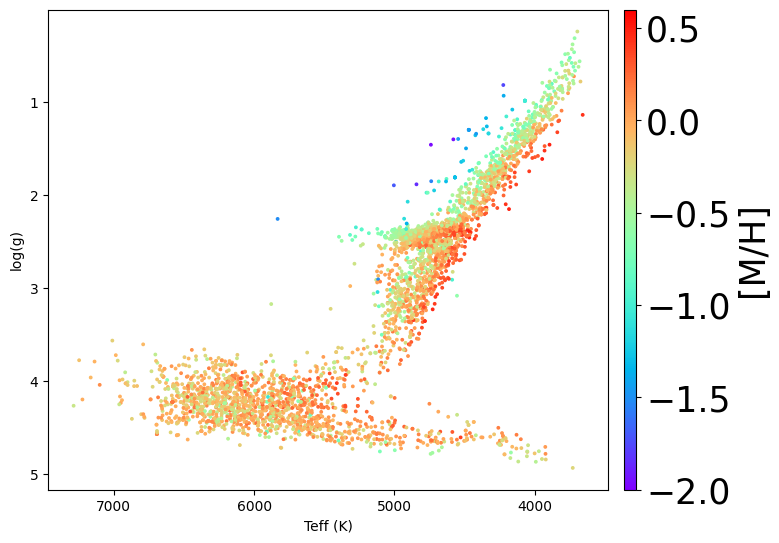

In [5]:
fig,ax=plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey=True,sharex=True,gridspec_kw={'hspace': 0,'wspace': 0})
plt.rcParams.update({'font.size': 25})

cs=plt.scatter(labels_ts.Teff, labels_ts.logg, c = labels_ts.MH, cmap="rainbow",s=3, vmin=-2.0,vmax=+0.6)
plt.xlabel('Teff (K)')
plt.ylabel("log(g)")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.82, 0.1, 0.015, 0.8])
cbar = fig.colorbar(cs, cax=cb_ax,label='[M/H]')

In [6]:
labels = labels_ts[label_names].values.astype('float32')
labels.shape
print(labels.shape)

(3904, 3)


### READ THE TRAINING SAMPLE SPECTRA

In [7]:
hdu = fits.open('Data/training_sample_spectra.fits')
spectra = hdu[0].data
hdu.close()
print("The " + str(spectra.shape[1]) + " training sample spectra have " + str(spectra.shape[0]) + " pixels")

The 3904 training sample spectra have 912 pixels


Text(0, 0.5, 'F')

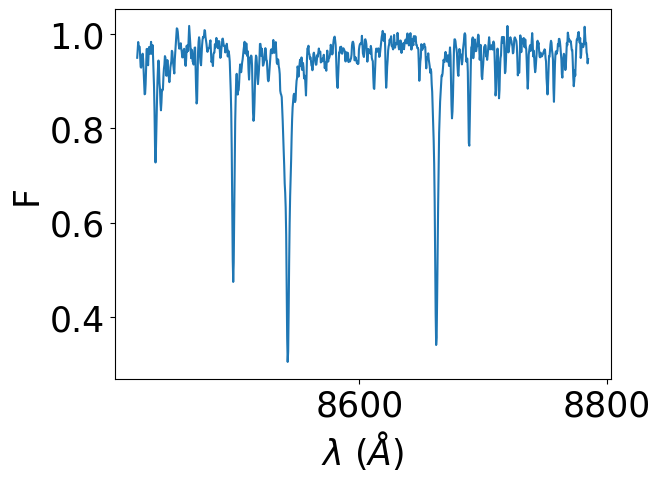

In [8]:
### EXAMPLE  OF RAVE SPECTRUM
plt.plot(wavelength, spectra[:,0])
plt.xlabel('$\lambda$ ($\AA$)')
plt.ylabel("F")

### READ THE TRAINING SAMPLE MAGNITUDES, PARALLAXES, AND EXTINCTION

In [9]:
params = pd.read_csv("Data/training_sample_parameters.csv")
print(params.columns, params.shape)

Index(['parallax', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
       'Jmag_2MASS', 'Hmag_2MASS', 'Kmag_2MASS', 'wise1', 'wise2', 'av50'],
      dtype='object') (3904, 10)


Text(0, 0.5, 'N')

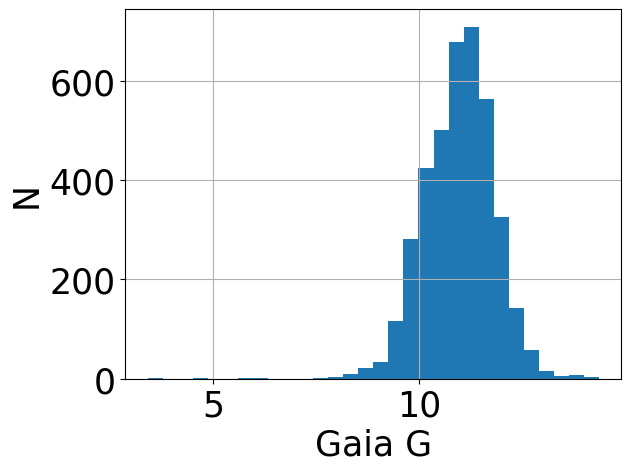

In [10]:
params.phot_g_mean_mag.hist(bins=30);
plt.xlabel('Gaia G')
plt.ylabel("N")

### SPLIT TRAINING SAMPLE INTO TRAINING AND TEST SAMPLES

In [11]:
### RESHAPE THE SPECTRA AND CONVERT TO FLOAT 32
n_rows_spectra, n_columns_spectra = spectra.shape
spectra_matrix = spectra.T.reshape(n_columns_spectra, n_rows_spectra, 1)
spectra_matrix = spectra_matrix.astype('float32')
spectra_matrix.shape

(3904, 912, 1)

In [12]:
### RESHAPE THE PARAMETERS AND CONVERT TO FLOAT 32
n_rows_parameters, n_columns_parameters = params.shape
parameters_matrix = params.values.reshape(n_rows_parameters, n_columns_parameters, 1)
parameters_matrix = parameters_matrix.astype('float32')
parameters_matrix.shape

(3904, 10, 1)

In [13]:
### CONCATENATE SPECTRA AND LABELS
data_matrix = np.concatenate((spectra_matrix, parameters_matrix), axis=1)
data_matrix.shape

(3904, 922, 1)

In [14]:
data_matrix.shape, labels.shape

((3904, 922, 1), (3904, 3))

In [15]:
### SPLIT DATA AND LABELS INTO TRAINING AND TEST SAMPLES
random_state = 42
X_train, X_test, y_train_s, y_test_s = train_test_split(data_matrix, labels, test_size = validation_percent_split, random_state=random_state)
X_train.shape, X_test.shape, y_train_s.shape, y_test_s.shape

((3123, 922, 1), (781, 922, 1), (3123, 3), (781, 3))

In [16]:
X_train_spec    = X_train[:,:n_rows_spectra,:]
X_train_param_s = X_train[:,n_rows_spectra:,:]
X_test_spec     = X_test[:,:n_rows_spectra,:]
X_test_param_s  = X_test[:,n_rows_spectra:,:]
X_train_spec.shape, X_train_param_s.shape, X_test_spec.shape, X_test_param_s.shape

((3123, 912, 1), (3123, 10, 1), (781, 912, 1), (781, 10, 1))

In [17]:
### RESCALE LABELS FROM 0 TO 1
scaler_y = preprocessing.MinMaxScaler()
y_train  = scaler_y.fit_transform(y_train_s)
y_test   = scaler_y.transform(y_test_s)

### RESCALE PARAMS FROM 0 TO 1
scaler_y_params = preprocessing.MinMaxScaler()
X_train_param   = scaler_y_params.fit_transform(X_train_param_s[:,:,0])
X_test_param    = scaler_y_params.transform(X_test_param_s[:,:,0])

X_train_param   = X_train_param.reshape(X_train_param.shape[0], X_train_param.shape[1], 1)
X_test_param    = X_test_param.reshape(X_test_param.shape[0],   X_test_param.shape[1],  1)

### NO NEED TO RESCALE THE SPECTRA, ALREADY BETWEEN 0 AND 1 ;)

In [18]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience_n, verbose=1, mode='auto')

iptdim = len(X_train_spec[0])
iptdim_mag = len(X_train_param[0])

iptdim, iptdim_mag

(912, 10)

### ARCHITECTURE OF THE CNN

In [19]:
def architecture(iptdim, iptdim_mag, use_phot):

    ipt       = Input(shape=(iptdim, 1))     #INPUT DIMENSION OF THE SPECTROSCOPIC CHANNEL
    ipt_param = Input(shape=(iptdim_mag,1))  #INPUT DIMENSION OF THE PHOTOMETRIC CHANNEL
    ipt_all = [ipt]

    x = Convolution1D(16, 10, padding='valid', name = 'convol_1')(ipt)   #CONVOLUTION LAYER 1
    x = LeakyReLU()(x)
    x = SpatialDropout1D(0.2)(x)
    x = Convolution1D(8, 10, padding='valid', name = 'convol_2')(x)     #CONVOLUTION LAYER 2
    x = LeakyReLU()(x)
    x = SpatialDropout1D(0.2)(x)
    x = Convolution1D(4, 10, padding='valid', name = 'convol_3')(x)     #CONVOLUTION LAYER 3
    x = LeakyReLU()(x)
    x = SpatialDropout1D(0.2)(x)

    x = Dropout(0.2)(x)    #DROPOUT LAYER

    x = Flatten()(x)
    x = Dense(32)(x)       #FULLY CONNECTED LAYER
    x = LeakyReLU()(x)

    if(use_phot==True):
        y = Flatten()(ipt_param)
        y = Dense(27)(y)              #FULLY CONNECTED LAYER OF THE PHOTOMETRY
        y = LeakyReLU()(y)
        x = concatenate([x, y])       #COMBINING SPECTRA AND PHOTOMETRY
        ipt_all = [ipt, ipt_param]

    x = Dense(16)(x)
    x = LeakyReLU()(x)

    cnnout = Dense(y_train.shape[1], activation='linear')(x)  #OUTPUT LAYER
    cnn = Model(ipt_all, cnnout)

    return cnn

In [20]:
cnn = architecture(iptdim, iptdim_mag, use_phot)
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 912, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convol_1 (Conv1D)   │ (None, 903, 16)   │        176 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 903, 16)   │          0 │ convol_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 903, 16)   │          0 │ leaky_re_lu[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convol_2 (Conv1D)   │ (None, 894, 8)    │      1,288 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 894, 8)    │          0 │ convol_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 894, 8)    │          0 │ leaky_re_lu_1[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convol_3 (Conv1D)   │ (None, 885, 4)    │        324 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 885, 4)    │          0 │ convol_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 885, 4)    │          0 │ leaky_re_lu_2[0]… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 885, 4)    │          0 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3540)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │    113,312 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 27)        │        297 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 32)        │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 27)        │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 59)        │          0 │ leaky_re_lu_3[0]… │
│ (Concatenate)       │                   │            │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 116,408 (454.72 KB)

 Trainable params: 116,408 (454.72 KB)

 Non-trainable params: 0 (0.00 B)

### TRAIN CNN 

In [21]:
histories   = []

if(if_training == True):

    for index_run in range(n_run):

        cnn = architecture(iptdim, iptdim_mag, use_phot)
        cnn.compile(loss='mse', optimizer='Adam',metrics=['mse'])

        if(use_phot==False):
            history = cnn.fit([X_train_spec], y_train,
                              batch_size=16,
                              epochs=n_epoch_max,
                              validation_data=([X_test_spec], y_test),
                              verbose=0,
                              callbacks=[early_stop])
        if(use_phot==True):
            history = cnn.fit([X_train_spec, X_train_param], y_train,
                              batch_size=16,
                              epochs=n_epoch_max,
                              validation_data=([X_test_spec, X_test_param], y_test),
                              verbose=0, callbacks=[early_stop])
        histories.append(history)

        #SAVE THE CNN MODEL
        cnn.save('Models/model_version_' + v + '_' + str(use_phot) + '_%03d' % index_run)  # creates a HDF5 file
        print(index_run)

### SAVE THE HISTORIES

In [22]:
if(if_training == True):
    np.savez('Models/histories_v' + v + '_' + str(use_phot)+ '.npz', history= pd.DataFrame.from_dict(h.history for h in histories))#, allow_pickle=True))

### PLOT THE LOSS FUNCTION OF THE TRAINING SAMPLE AND TEST SAMPLE 

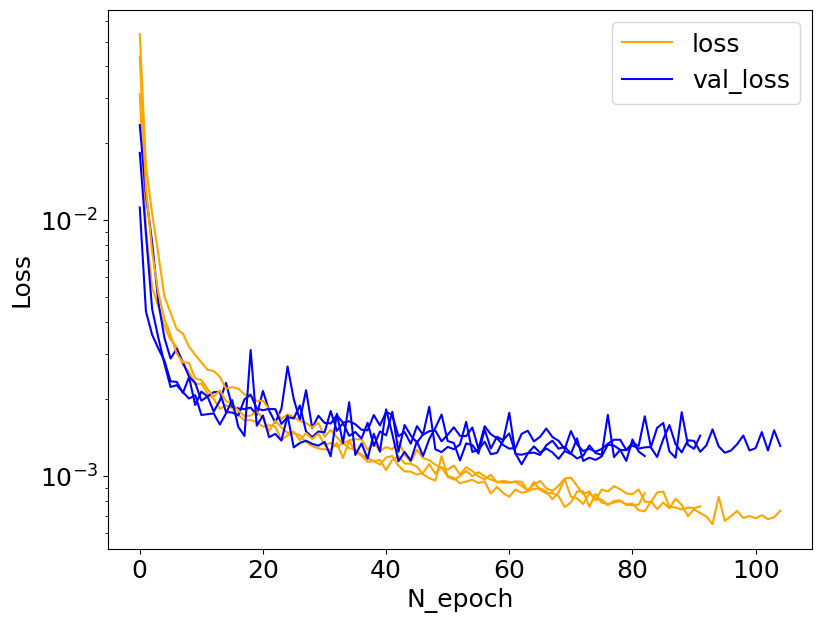

In [23]:
saved_h = np.load('Models/histories_v' + v + '_' + str(use_phot)+ '.npz', allow_pickle=True)

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(20,7))
plt.subplot(121)
for i in range(saved_h['history'].shape[0]):
    plt.plot(saved_h['history'][i,0], c='orange')
    plt.plot(saved_h['history'][i,2], c='b')
    plt.yscale('log')
    plt.xlabel("N_epoch")
    plt.ylabel("Loss")
    plt.legend(['loss','val_loss'])

### LOAD THE OBSERVATIONS

In [24]:
#loading spectra
obs = np.load('Data/observed_spectra.npz')
observed_spectra = obs["spec"].T
observed_spectra = np.asarray(observed_spectra.reshape(observed_spectra.shape[0], observed_spectra.shape[1], 1)).astype(np.float32)
observed_spectra.shape

(37772, 912, 1)

In [25]:
#loading params
params_obs = pd.read_csv('Data/observed_params.csv')
observed_params = scaler_y_params.transform(params_obs.values[:,1:])
observed_params = np.asarray(observed_params.reshape(observed_params.shape[0], observed_params.shape[1], 1)).astype(np.float32)
observed_params.shape

(37772, 10, 1)

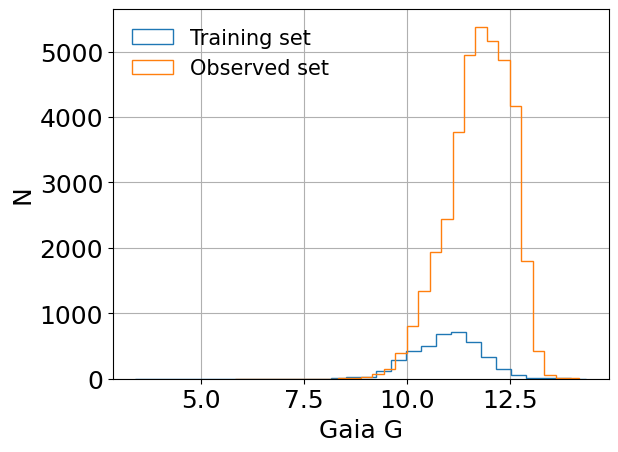

In [26]:
params.phot_g_mean_mag.hist(bins=30, histtype="step", label = "Training set");
plt.xlabel('Gaia G')
plt.ylabel("N")
params_obs.phot_g_mean_mag.hist(bins=30, histtype="step", label = "Observed set");
plt.legend(loc='upper left', frameon=False, fontsize=15)

### PREDICTS LABELS FOR TRAINING, TEST AND OBSERVED SAMPLES

In [27]:

if(if_predict == True):

    #Add together the n_runs
    res_train_all = np.zeros((n_run, y_train.shape[0],           y_train.shape[1]))      # (n_run, n_star, n_labels)
    res_test_all  = np.zeros((n_run, y_test.shape[0],            y_test.shape[1]))
    res_obs_all   = np.zeros((n_run, observed_spectra.shape[0],  y_test.shape[1]))

    for i in range(n_run):
        print(i)
        cnn = load_model('Models/model_version_' + v + '_' + str(use_phot) + '_%03d' % i)
        if(use_phot==False):
            res_train_all[i,:,:] = scaler_y.inverse_transform(cnn.predict([X_train_spec]))
            res_test_all[i,:,:]  = scaler_y.inverse_transform(cnn.predict([X_test_spec]))
            res_obs_all[i,:,:]   = scaler_y.inverse_transform(cnn.predict([observed_spectra]))
        if(use_phot==True):
            res_train_all[i,:,:] = scaler_y.inverse_transform(cnn.predict([X_train_spec,X_train_param]))
            res_test_all[i,:,:]  = scaler_y.inverse_transform(cnn.predict([X_test_spec,X_test_param]))
            res_obs_all[i,:,:]   = scaler_y.inverse_transform(cnn.predict([observed_spectra,observed_params]))


### COMPUTE MEAN LABELS OVER THE N RUNS, AND COMPUTE UNCERTAINTY

In [28]:
if(if_predict == True):

    final_res_train = np.mean(res_train_all, axis = 0)     #estimated labels of the training sample
    final_res_test  = np.mean(res_test_all,  axis = 0)     #estimated labels of the test sample
    final_res_obs   = np.mean(res_obs_all,  axis = 0)      #estimated labels of the observed sample

    final_std_error_train = np.std(res_train_all, axis = 0)
    final_std_error_test  = np.std(res_test_all,  axis = 0)
    final_std_error_obs   = np.std(res_obs_all,  axis = 0)

In [29]:
if(if_predict == True):

    df_res_train = pd.DataFrame(np.hstack((final_res_train,final_std_error_train)), columns=label_names + ["std_" + ITEM for ITEM in label_names])
    df_res_test  = pd.DataFrame(np.hstack((final_res_test, final_std_error_test)),  columns=label_names + ["std_" + ITEM for ITEM in label_names])
    df_res_obs   = pd.DataFrame(np.hstack((final_res_obs,  final_std_error_obs)),   columns=label_names + ["std_" + ITEM for ITEM in label_names])

    df_res_train.to_csv("Results/res_train_cnn_version_" + v + '_' + str(use_phot) + ".csv", index=False)
    df_res_test.to_csv("Results/res_test_cnn_version_"   + v + '_' + str(use_phot) + ".csv", index=False)
    df_res_obs.to_csv("Results/res_obs_cnn_version_"     + v + '_' + str(use_phot) + ".csv", index=False)

### COMPUTE AND SAVE GRADIENTS

In [30]:
if(if_training == True):

    arr = []

    ### COMPUTE GRADIENTS
    for index_run in range(n_run):
        print(index_run)

        cnn = load_model('Models/model_version_' + v + '_' + str(use_phot) + '_%03d' % index_run)

        eg = []
        spec = tf.Variable(X_test_spec, dtype=np.float32)
        par  = tf.Variable(X_test_param, dtype=np.float32)

        for i in range(y_train.shape[1]):
            with tf.GradientTape() as tape:
                tape.watch(spec)
                if(use_phot == True):
                    prediction = cnn([spec,par], training=False)
                if(use_phot == False):
                    prediction = cnn([spec], training=False)
                loss = tf.keras.losses.mse(y_train[:,i], prediction[:,i:i+1])
                grad = tape.gradient(prediction[:,i:i+1], spec)
                eg.append(grad)
        arr1 = np.array(eg)
        arr.append(arr1)

        del eg, spec, par, loss, grad, arr1, prediction

    arr = np.array(arr)


In [31]:
if(if_training == True):
    arr.shape
# 3 runs, 3 labels, 781 spectra, 912 pixels, 1 extra dim

In [32]:
# SAVE GRADIENTS
if(if_training == True):
    gradient = np.mean(arr[:,:,:,:,0],axis=0) #compute mean over the 3 CNN runs
    np.savez('Models/gradients_' + v +'_'+ str(use_phot) + '.npz', gradients= gradient)
    gradient.shape

### BASIC PLOTS

In [33]:
### READ RESULTS
df_res_train = pd.read_csv("Results/res_train_cnn_version_" + v + '_' + str(use_phot) + ".csv")
df_res_test  = pd.read_csv("Results/res_test_cnn_version_"  + v + '_' + str(use_phot) + ".csv")
df_res_obs   = pd.read_csv("Results/res_obs_cnn_version_"   + v + '_' + str(use_phot) + ".csv")
grad         = np.load('Models/gradients_'                  + v + '_' + str(use_phot) + '.npz')

### KIEL DIAGRAM OF TRAINING AND TEST SAMPLE

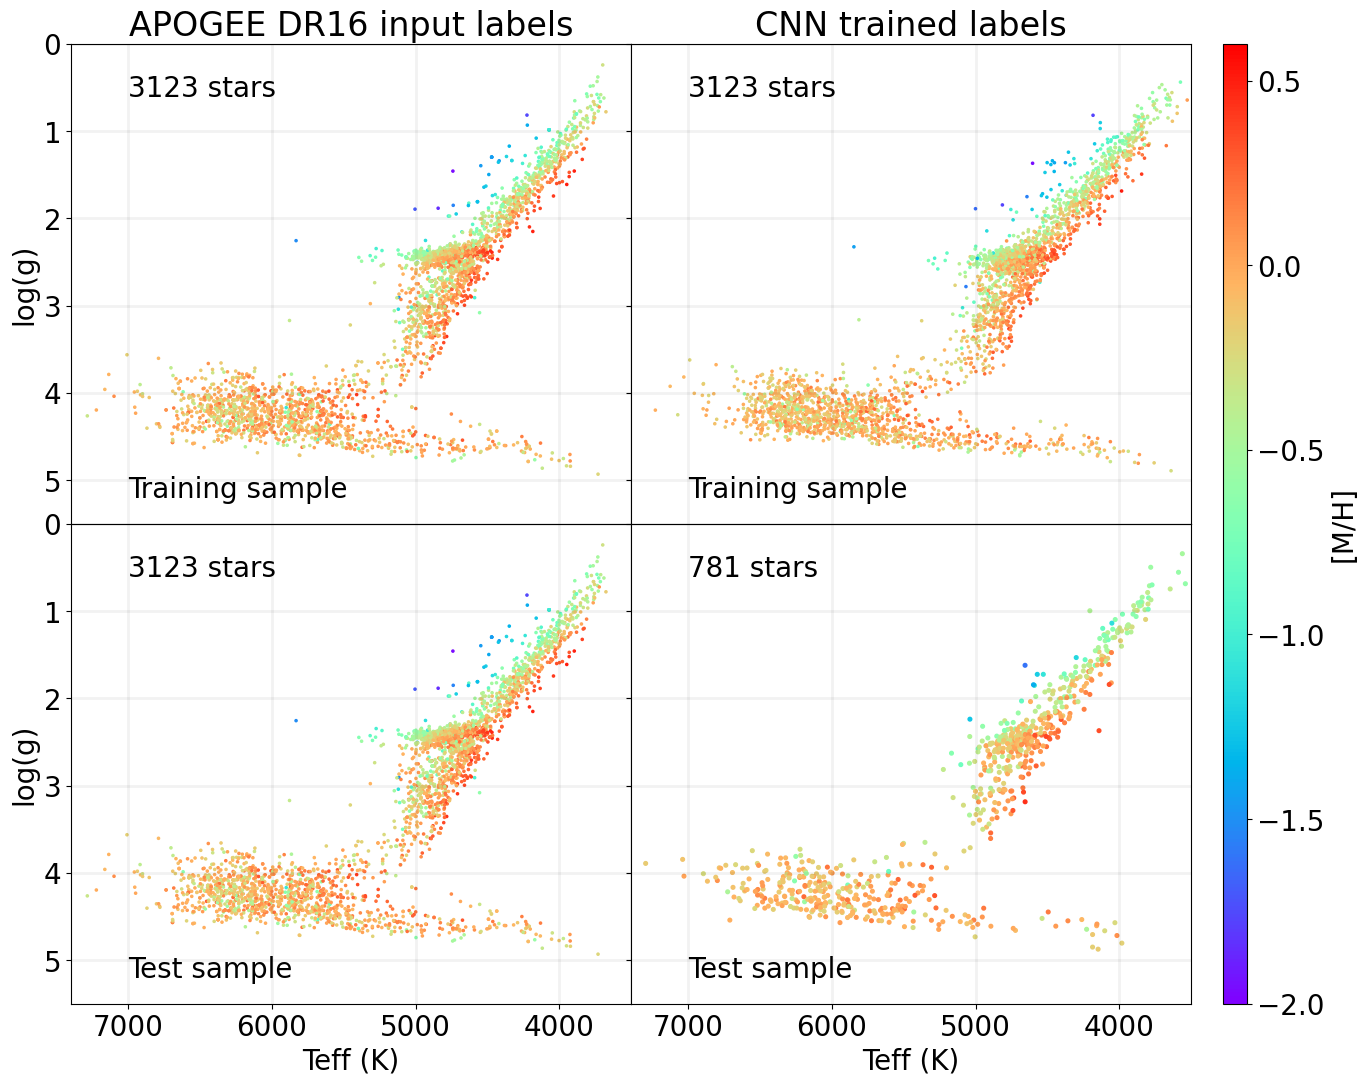

In [35]:
fig,ax=plt.subplots(nrows=2, ncols=2, figsize=(16, 12), sharey=True,sharex=True,gridspec_kw={'hspace': 0,'wspace': 0})
plt.rcParams.update({'font.size': 20})

cs=ax[0,0].scatter(y_train_s[:,0], y_train_s[:,1], c=y_train_s[:,2],s=2.5,cmap='rainbow', vmin=-2.0,vmax=+0.6, rasterized=True)
ax[0,0].set_xlim([7400.0, 3500.0])
ax[0,0].set_ylim([5.5, 0.0])
ax[0,0].set_xlabel('Teff (K)')
ax[0,0].set_ylabel('log(g)')
ax[0,0].set_title("APOGEE DR16 input labels")
ax[0,0].text(7000.0, +0.6, str(len(y_train[:,0])) + " stars", color='black')
ax[0,0].text(7000.0, +5.2, "Training sample", color='black')
ax[0,0].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

cs=ax[0,1].scatter(df_res_train.Teff, df_res_train.logg, c=df_res_train.MH,s=2.52,cmap='rainbow', vmin=-2.0,vmax=+0.6, rasterized=True)
ax[0,1].set_xlim([7400.0, 3500.0])
ax[0,1].set_ylim([5.5, 0.0])
ax[0,1].set_title("CNN trained labels")
ax[0,1].text(7000.0, +0.6, str(len(df_res_train.Teff)) + " stars", color='black')
ax[0,1].text(7000.0, +5.2, "Training sample", color='black')
ax[0,1].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

cs=ax[1,0].scatter(y_train_s[:,0], y_train_s[:,1], c=y_train_s[:,2],s=2.5,cmap='rainbow', vmin=-2.0,vmax=+0.6, rasterized=True)
ax[1,0].set_xlim([7400.0, 3500.0])
ax[1,0].set_ylim([5.5, 0.0])
ax[1,0].set_xlabel('Teff (K)')
ax[1,0].set_ylabel('log(g)')
ax[1,0].text(7000.0, +0.6, str(len(y_train[:,0])) + " stars", color='black')
ax[1,0].text(7000.0, +5.2, "Test sample", color='black')
ax[1,0].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

cs=ax[1,1].scatter(df_res_test.Teff, df_res_test.logg, c=df_res_test.MH,s=7.0,cmap='rainbow', vmin=-2.0,vmax=+0.6, rasterized=True)
ax[1,1].set_xlim([7400.0, 3500.0])
ax[1,1].set_ylim([5.5, 0.0])
ax[1,1].set_xlabel('Teff (K)')
ax[1,1].text(7000.0, +0.6, str(len(df_res_test.Teff)) + " stars", color='black')
ax[1,1].text(7000.0, +5.2, "Test sample", color='black')
ax[1,1].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.82, 0.1, 0.015, 0.8])
cbar = fig.colorbar(cs, cax=cb_ax,label='[M/H]')

### ONE TO ONE COMPARISON BETWEEN INPUT AND PREDICTED LABELS FOR THE TRAINING AND TEST SAMPLES

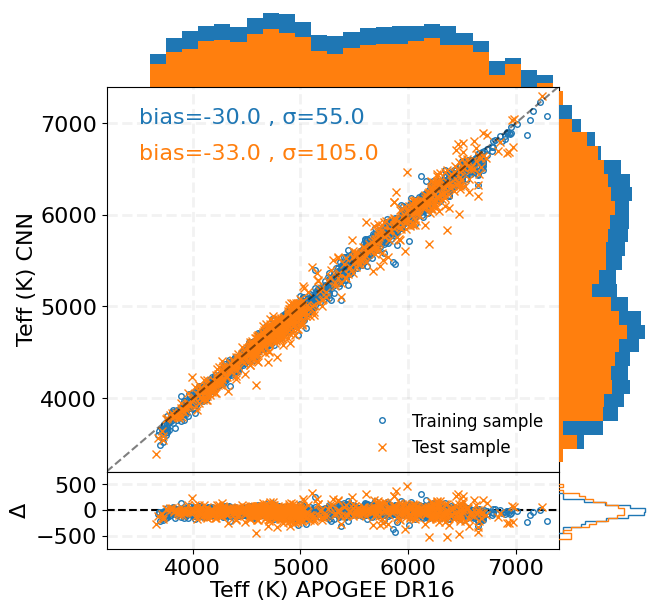

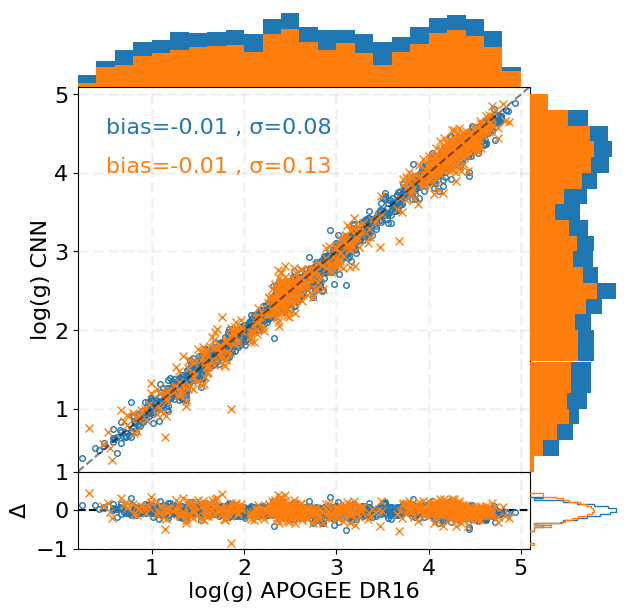

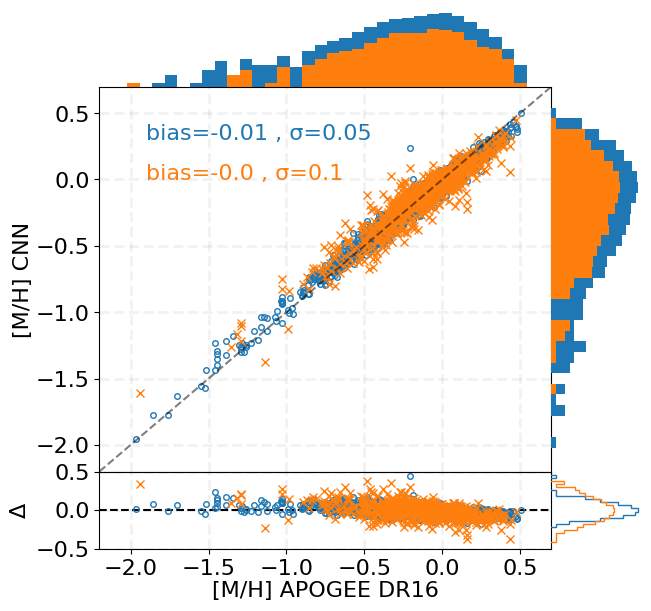

In [36]:
xmine = [3200.0, +0.2, -2.2]
xmaxe = [7400.0, +5.1, +0.7]
ymine = [-750.0, -1.0, -0.5]
ymaxe = [+750.0, +1.0, +0.5]
x_disp = [3500.0, 0.5, -1.9]
y_disp = [7000.0, 4.5, +0.3]
corr   = [400.0, 0.5, 0.3]

plt.rcParams.update({'font.size': 16})
ct=0

xmin_histo  = [3000.0, +0.0, -2.5]
xmax_histo  = [8000.0, +5.5, +0.8]
bin_histo   = [150.0, 0.2, 0.08]
bin_histo2  = [60.0, 0.05, 0.04]

for ii, elem in enumerate(label_names):
    arond=2
    ct=ct+1
    fig = plt.figure(figsize=(7, 7))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.2,1.0,0.2], width_ratios=[1.0,0.2]) #(line, column)

    ax3 = plt.subplot(gs[0,0])
    ax3.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax3.hist(y_train_s[:,ii], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    ax3.hist(y_test_s[:,ii],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    ax3.set_xlabel(xlab[ct-1] + " APOGEE DR16", labelpad=2)
    ax3.set_xlim(xmine[ct-1], xmaxe[ct-1])
    plt.axis('off')

    ax0 = plt.subplot(gs[1,0], sharex = ax3)
    plt.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax0.plot(y_train_s[:,ii], df_res_train[elem], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    ax0.plot(y_test_s[:,ii],  df_res_test[elem],  'x', markersize=6.0, color='#ff7f0e')
    ax0.set_xlim(xmine[ct-1], xmaxe[ct-1])
    ax0.set_ylim(xmine[ct-1], xmaxe[ct-1])
    ax0.set_ylabel(xlab[ct-1] + " CNN",labelpad=2)
    if(ct==1):
        arond=0
        plt.legend(["Training sample", "Test sample"], loc='lower right', frameon=False, prop={'size': 12})
    ax0.plot([xmine[ct-1], xmaxe[ct-1]], [xmine[ct-1], xmaxe[ct-1]],linestyle='--',color='black', alpha=0.5)
    ax0.text(x_disp[ct-1], y_disp[ct-1], "bias="+str(round(np.mean(df_res_train[elem]-y_train_s[:,ii]),arond)) + 
             " , \u03C3=" + str(round(np.std(df_res_train[elem]-y_train_s[:,ii]),arond)),color='#1f77b4')
    ax0.text(x_disp[ct-1], y_disp[ct-1]-corr[ct-1], "bias="+str(round(np.mean(df_res_test[elem] -y_test_s[:,ii]),arond))  + 
             " , \u03C3=" + str(round(np.std(df_res_test[elem] -y_test_s[:,ii]),arond)), color='#ff7f0e')

    ax1 = plt.subplot(gs[1,1], sharey = ax0)
    ax1.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax1.hist(df_res_train[elem], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    ax1.hist(df_res_test[elem],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    plt.subplots_adjust(wspace=.0)
    plt.axis('off')

    ax2 = plt.subplot(gs[2,0], sharex = ax0)
    ax2.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax2.plot([xmine[ct-1], xmaxe[ct-1]], [0.0, 0.0],linestyle='--',color='black')
    ax2.plot(y_train_s[:,ii], df_res_train[elem] - y_train_s[:,ii], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    ax2.plot(y_test_s[:,ii],  df_res_test[elem]  - y_test_s[:,ii],  'x', markersize=6.0, color='#ff7f0e')
    ax2.set_xlim(xmine[ct-1], xmaxe[ct-1])
    ax2.set_ylim(ymine[ct-1], ymaxe[ct-1])
    ax2.set_ylabel("\u0394")
    plt.subplots_adjust(hspace=.0)
    ax2.set_xlabel(xlab[ct-1] + " APOGEE DR16",labelpad=2)

    ax4 = plt.subplot(gs[2,1], sharey = ax2)
    ax4.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax4.hist(df_res_train[elem] - y_train_s[:,ii], bins=(np.arange(ymine[ct-1], ymaxe[ct-1], bin_histo2[ct-1])),
             log=True, orientation='horizontal', histtype = 'step')
    ax4.hist(df_res_test[elem]  - y_test_s[:,ii],  bins=(np.arange(ymine[ct-1], ymaxe[ct-1], bin_histo2[ct-1])),
             log=True, orientation='horizontal', histtype = 'step')
    plt.subplots_adjust(wspace=.0)
    plt.axis('off')

### PLOT GRADIENTS FOR THE TEST SET

In [37]:
gradient = grad["gradients"]
gradient.shape

(3, 781, 912)

912
912
912


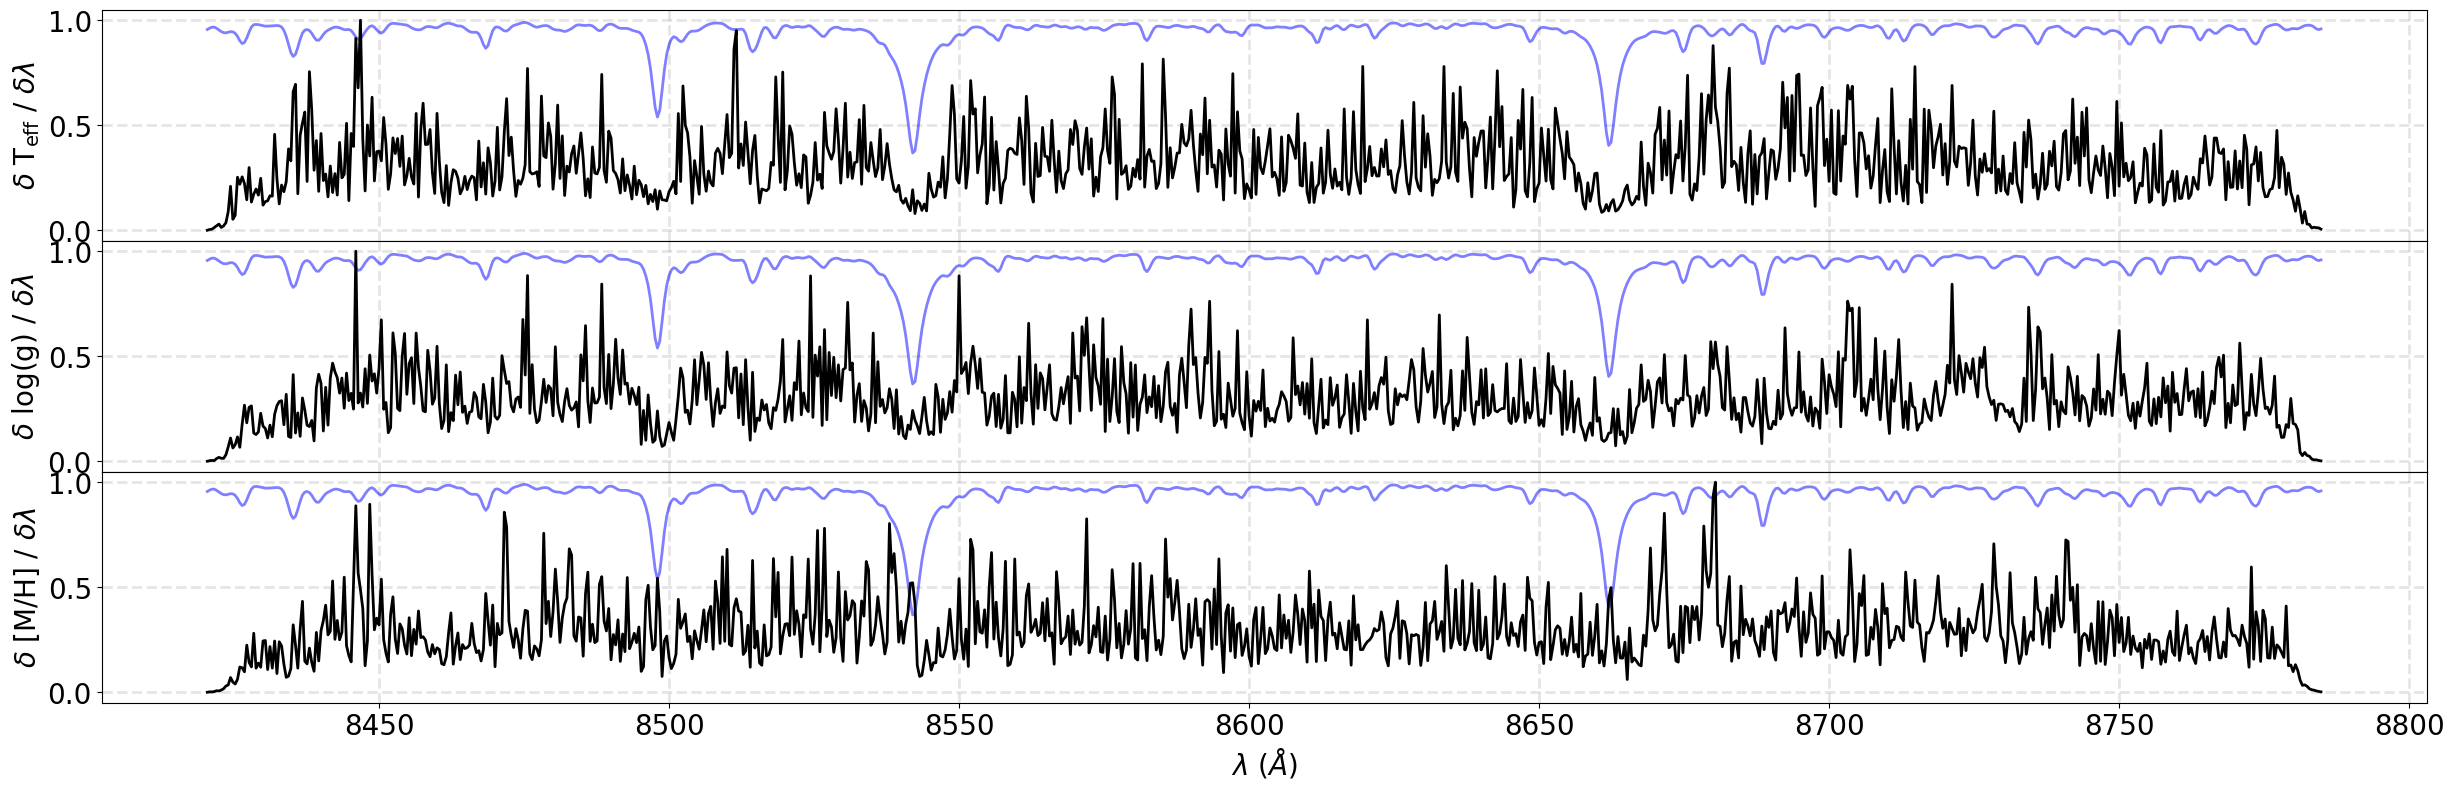

In [38]:
ytitle = ['$\delta$ $\mathrm{T}_{\mathrm{eff}}$ / $\delta \lambda$', '$\delta$ log(g) / $\delta \lambda$', '$\delta$ [M/H] / $\delta \lambda$']
plt.rcParams.update({'font.size': 20})
fig,ax=plt.subplots(nrows=len(label_names), ncols=1, figsize=(30,3*3), sharey=True,sharex=True,gridspec_kw={'hspace': 0,'wspace': 0})

for jj in range(len(label_names)):
    #www = (y_train[:,0] <4500) & (y_train[:,1] < 4.0)# & (y_train[:,2] < -1.0)
    tmp_gradient = np.linalg.norm(gradient[jj,:,:], axis=0)
    print(len(tmp_gradient))
    tmp_gradient = (tmp_gradient - tmp_gradient.min()) / (tmp_gradient.max() - tmp_gradient.min())

    ax[jj].grid(color='black', linestyle='--', linewidth=2, alpha=0.1)

    ax[jj].plot(wavelength, np.mean(X_test_spec[:,:,0], axis=0), c = 'blue', alpha=0.5, lw = 2)
    ax[jj].plot(wavelength, tmp_gradient, c = 'black', lw = 2)
    if jj == 2: ax[jj].set_xlabel('$\lambda$ ($\AA$)')
    ax[jj].set_ylabel(ytitle[jj])

### PLOT KIEL DIAGRAM OF THE OBSERVED SAMPLE

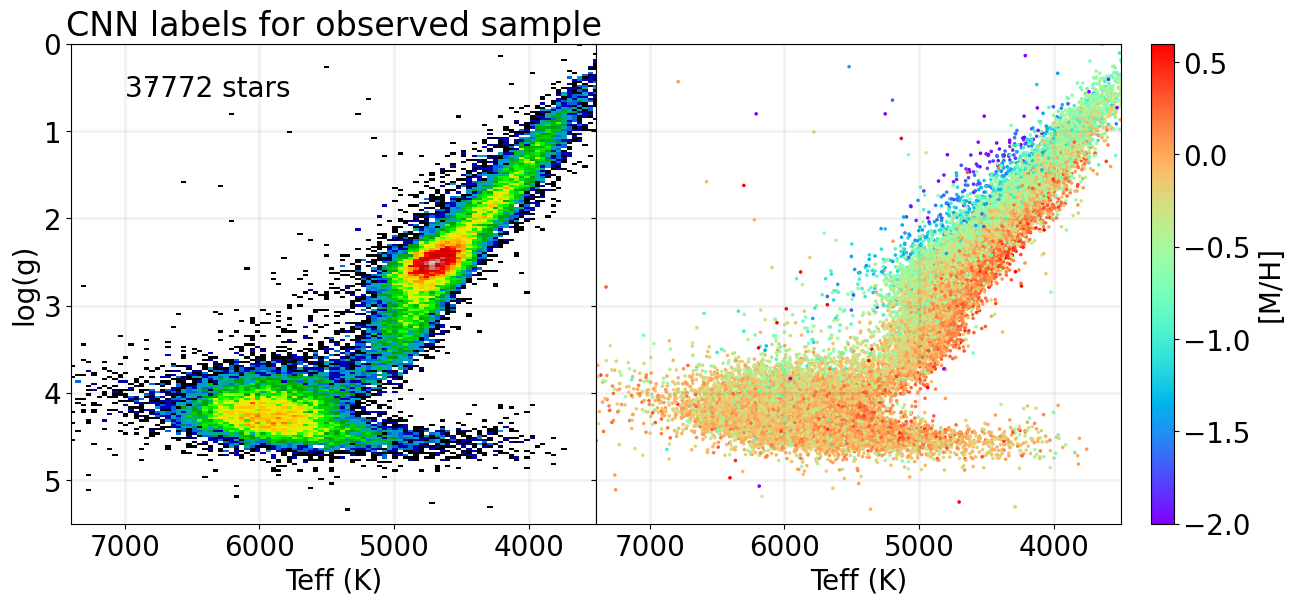

In [41]:
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True,sharex=True,gridspec_kw={'hspace': 0,'wspace': 0})
plt.rcParams.update({'font.size': 20})

ax[0].hist2d(df_res_obs.Teff, df_res_obs.logg, cmap='nipy_spectral', bins=400, norm=LogNorm())
ax[0].set_xlim([7400.0, 3500.0])
ax[0].set_ylim([5.5, 0.0])
ax[0].set_xlabel('Teff (K)')
ax[0].set_ylabel('log(g)')
ax[0].set_title("CNN labels for observed sample")
ax[0].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)
ax[0].text(7000.0, +0.6, str(len(df_res_obs)) + " stars", color='black')

cs=ax[1].scatter(df_res_obs.Teff, df_res_obs.logg, c=df_res_obs.MH,s=2.5,cmap='rainbow', vmin=-2.0,vmax=+0.6, rasterized=True)
ax[1].set_xlim([7400.0, 3500.0])
ax[1].set_ylim([5.5, 0.0])
ax[1].set_xlabel('Teff (K)')
ax[1].grid(color='black', linestyle='-', linewidth=2, alpha=0.05)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.82, 0.1, 0.015, 0.8])
cbar = fig.colorbar(cs, cax=cb_ax,label='[M/H]')


